<a href="https://colab.research.google.com/github/ckakalou/medCAT/blob/main/MedCAT_Tutorial_%7C_Part_3_2_Extracting_Diseases_from_Electronic_Health_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade medcat
# Get the scispacy model
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.3.0/en_core_sci_lg-0.3.0.tar.gz

     |████████████████████████████████| 133kB 14.2MB/s 
     |████████████████████████████████| 358kB 23.7MB/s 
     |████████████████████████████████| 10.4MB 17.2MB/s 
     |████████████████████████████████| 15.3MB 186kB/s 
     |████████████████████████████████| 225kB 36.7MB/s 
     |████████████████████████████████| 2.1MB 31.1MB/s 
     |████████████████████████████████| 27.4MB 117kB/s 
     |████████████████████████████████| 24.2MB 118kB/s 
     |████████████████████████████████| 1.1MB 25.5MB/s 
     |████████████████████████████████| 122kB 41.1MB/s 
     |████████████████████████████████| 245kB 45.8MB/s 
     |████████████████████████████████| 901kB 27.6MB/s 
     |████████████████████████████████| 3.3MB 32.6MB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2

**Restart the runtime if on colab, sometimes necessary after installing models**

In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt

from medcat.vocab import Vocab
from medcat.cdb import CDB
from medcat.config import Config
from medcat.cdb_maker import CDBMaker
from medcat.cat import CAT

In [ ]:
DATA_DIR = "./data/"
vocab_path = DATA_DIR + "vocab.dat"
cdb_path = DATA_DIR + "cdb-medmen-v1.dat"

In [ ]:
# Download the models and required data
!wget https://medcat.rosalind.kcl.ac.uk/media/vocab.dat -P ./data/
!wget https://medcat.rosalind.kcl.ac.uk/media/cdb-medmen-v1.dat -P ./data/
!wget https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./data/

--2021-06-10 21:54:25--  https://medcat.rosalind.kcl.ac.uk/media/vocab.dat
Resolving medcat.rosalind.kcl.ac.uk (medcat.rosalind.kcl.ac.uk)... 193.61.202.225
Connecting to medcat.rosalind.kcl.ac.uk (medcat.rosalind.kcl.ac.uk)|193.61.202.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274445907 (262M) [application/octet-stream]
Saving to: ‘./data/vocab.dat’

vocab.dat           100%[===================>] 261.73M  21.3MB/s    in 14s     

2021-06-10 21:54:39 (19.1 MB/s) - ‘./data/vocab.dat’ saved [274445907/274445907]

--2021-06-10 21:54:39--  https://medcat.rosalind.kcl.ac.uk/media/cdb-medmen-v1.dat
Resolving medcat.rosalind.kcl.ac.uk (medcat.rosalind.kcl.ac.uk)... 193.61.202.225
Connecting to medcat.rosalind.kcl.ac.uk (medcat.rosalind.kcl.ac.uk)|193.61.202.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356087008 (340M) [application/octet-stream]
Saving to: ‘./data/cdb-medmen-v1.dat’

cdb-medmen-v1.dat   100%[==================

## Loading models and preparing MedCAT

In [ ]:
# Create and load the CDB (Concept Database)
cdb = CDB.load(cdb_path)

# Create and load the Vocabulary
vocab = Vocab.load(vocab_path)

In [ ]:
# Set a couple of parameters, they are usually set via environments, but
#here we will do it explicitly. You can read more about each option in the 
#medcat repository: https://github.com/CogStack/MedCAT
cdb.config.ner['min_name_len'] = 2
cdb.config.ner['upper_case_limit_len'] = 3
cdb.config.general['spell_check'] = True
cdb.config.linking['train_count_threshold'] = 10
cdb.config.linking['similarity_threshold'] = 0.3
cdb.config.linking['train'] = True
cdb.config.linking['disamb_length_limit'] = 5
cdb.config.general['full_unlink'] = True


# Create CAT - the main class from medcat used for concept annotation
cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab)

## Testing NER+L

In [ ]:
text = "He was diagnosed with kidney failure"
doc = cat(text)
print(doc.ents)

(diagnosed, kidney failure)


In [ ]:
# To see all entities and corresponding meta-data
cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {0: {'acc': 0.22160544957937056,
   'context_similarity': 0.22160544957937056,
   'cui': 'C1704656',
   'detected_name': 'diagnosed',
   'end': 16,
   'icd10': [],
   'id': 0,
   'meta_anns': {},
   'ontologies': [],
   'pretty_name': 'Diagnosis Study',
   'snomed': [],
   'source_value': 'diagnosed',
   'start': 7,
   'tuis': ['T062'],
   'types': ['Research Activity']},
  2: {'acc': 1.0,
   'context_similarity': 1.0,
   'cui': 'C0035078',
   'detected_name': 'kidney~failure',
   'end': 36,
   'icd10': [],
   'id': 2,
   'meta_anns': {},
   'ontologies': [],
   'pretty_name': 'Kidney Failure',
   'snomed': [],
   'source_value': 'kidney failure',
   'start': 22,
   'tuis': ['T047'],
   'types': ['Disease or Syndrome']}},
 'tokens': []}

In [ ]:
# If we want to see the CUI (ID) for each entity
for ent in doc.ents:
    print(ent, " - ", ent._.cui)

diagnosed  -  C1704656
kidney failure  -  C0035078


In [ ]:
# To show semantic types for each entity
for ent in doc.ents:
  print(ent, " - ", cdb.cui2type_ids.get(ent._.cui))

diagnosed  -  {'T062'}
kidney failure  -  {'T047'}


In [ ]:
# We can also show the entities in a nicer way using displacy form spaCy
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

## Load the data

In [ ]:
# Load the dataset - the one we saved in the last step of Part 2.
#If using MIMIC-III this is a very big dataset, be careful with memory requirements.
data = pd.read_csv(DATA_DIR + "pt_notes.csv")

In [ ]:
# In this step we are only interested in the *text* column
data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
0,6,1,2079-01-01,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
1,7,1,2079-01-01,Rheumatology,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079,1,F,2018-01-01,2018,61
2,8,1,2079-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
3,9,2,2037-01-01,Consult - History and Phy.,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037,2,F,2018-01-01,2018,19
4,10,2,2037-01-01,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037,2,F,2018-01-01,2018,19


## Run unsupervised training

In [ ]:
# The first step that we want to do when using MedCAT is unsupervised training.
# You can find a full explanation of this process in the paper:
# https://doi.org/10.1016/j.artmed.2021.102083

# Print statistics on the CDB before training (note that if you are using the 
#medmen cdb it will already have some training)
cat.cdb.print_stats()

# Run the annotation procedure over all the documents we have,
#given that we have a large number of documents this can take quite some time.
#~2 days, but you don't need to run it over everything 500K docs is enough
print()
print(f"There are {len(data['text'])} documents to train...")
cat.train(data.text.values, progress_print=100)

# Print statistics on the CDB after training
cat.cdb.print_stats()

Number of concepts: 34,724
Number of names:    92,740
Number of concepts that received training: 34,724
Number of seen training examples in total: 4,079,076
Average training examples per concept:     117.5


There are 1088 documents to train...


DONE: 0
DONE: 100
DONE: 200
DONE: 300
DONE: 400
DONE: 500
DONE: 600
DONE: 700
DONE: 800
DONE: 900
DONE: 1000
Number of concepts: 34,724
Number of names:    92,740
Number of concepts that received training: 34,724
Number of seen training examples in total: 4,097,966
Average training examples per concept:     118.0


## Save the new CDB

In [ ]:
cdb.save("my_new_medcat_cdb.dat")

In [ ]:
cdb = CDB.load("my_new_medcat_cdb.dat")

## Annotate Documents

We are not interested in all medical concepts that exist in UMLS, that is why we will filter by Semantic Type (TUI) to only:
1. T047 - Disease or Syndrome
2. T048 - Mental or Behavioral Dysfunction

It is possible to filter after the detection process, but always better to define the filter as part of MedCAT

A full list of semantic types in UMLS is available [here](https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt).

In [ ]:
# IMPORTANT: Set TUI filters
# |T047|Disease or Syndrome
# |T048|Mental or Behavioral Dysfunction
tui_filter = ['T047', 'T048']
cui_filters = set()
for tui in tui_filter:
  cui_filters.update(cdb.addl_info['type_id2cuis'][tui])
cdb.config.linking['filters']['cuis'] = cui_filters
print(f"The size of the cdb is now: {len(cui_filters)}")


The size of the cdb is now: 1763


In [ ]:
# Make sure to reload the CAT with the new cdb config
cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab)

For each row in our dataframe `data` we want to get all diseases that appear in the `text` column. In UMLS a disease is defined by a CUI, so we want to have the following output after the annotation is done:
```
cui_location = {<CUI>: [<row_id>, <row_id>, ...], ...}
```

In [ ]:
# This will be a map from CUI to a list of documents where it appears: {"cui": [<doc_id>, <doc_id>, ...], ..}
cui_location = {}
# Let's also save the TUI location (semantic type)
tui_location = {}

### Use Multiprocessing

We can annotate documents one by one, using the `annotated_document = cat(text)` option, but it will work much faster if we do it using the `multi_processing` method from medcat.

When using multi_processing medcat requires the following format for input documents:
```
in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
```
The output is (return from medcat):
```
out_data = [(doc_id, {'entities': [...], 'text': <...>), (doc_id, {'entities': [...], 'text': <...>}), ...]
```

NOTE: If using the full UMLS CDB and a lot of processors (e.g. 32) it is very memory demanding (~ 32GB). The annotation process on 32 processors and 1M large text documents takes ~1h. 

In [ ]:
# Let's test the multi processing function first
in_data = [(1, "He was a diabetic patient")]
results = cat.multiprocessing(in_data, nproc=2)
print(results)

[(1, {'entities': {}, 'tokens': [], 'text': 'He was a diabetic patient'})]


The returned list of `entities` contains the following:

`cui` - ID of the detected entity in the CDB (in our case UMLS)

`tui` - Semantic type ID

`type` - Semantic type

`source_value` - What exact source value was detected

`acc` - Confidence score for this detection

`start` - The start character for the entity in the original string

`end` - End character for the entity in the original string

`id` - Internal ID, each entity inside a document has an unique ID

`pretty_name` - The pretty name for this entity linked with the CUI

`icd10` - If we are using a medical CDB, we'll also get ICD10 codes

`umls` - If the CDB was something other than UMLS, we would get the potential link to UMLS.

`snomed` - If we are using a medical CDB this would link to the equivalent SNOMED concept

In [ ]:
# If we have a use-case (like ours) where we do not care about anything else but the 
#detected CUI (concept unique identifier), we can do the following:
in_data = [(1, "He was a diabetic patient")]
results = cat.multiprocessing(in_data, nproc=2, only_cui=True)
print(results)

[(1, {'entities': {}, 'tokens': [], 'text': 'He was a diabetic patient'})]


In [ ]:
data.shape

(1088, 11)

In [ ]:
batch_size = 100
batch = []
cnt = 0
for id, row in data.iterrows():
    text = row['text']
    # Skip text if under 10 characters
    if len(text) > 10:
        batch.append((id, text))
    
    if len(batch) > batch_size or id == len(data) - 1:
        # Update the number of processors depending on your machine.
        #We are using the only_cui option, means the returned entities
        #will only have a CUI (no other information, try both if interested).
        results = cat.multiprocessing(batch, nproc=8, only_cui=True)
        
        for pair in results:
            row_id = pair[0]
            cui_list = set(pair[1]['entities'].values()) # Convert to set to get unique CUIs
            
            for cui in cui_list:
                if cui in cui_location:
                    cui_location[cui].append(row_id)
                else:
                    cui_location[cui] = [row_id]

                # This is not necessary as it can be done later, we have
                #the cdb.cui2type_id map.
                tuis = cdb.cui2type_ids[cui] 
                for tui in tuis: # this step is necessary as one cui may map to several tuis
                  if tui in tui_location and row_id not in tui_location[tui]:
                      tui_location[tui].append(row_id)
                  elif tui not in tui_location:
                      tui_location[tui] = [row_id]
        
        cnt += 1
        print("Done: {} - rows".format((cnt -1)*batch_size + len(batch)))
        
        # Reset the batch
        batch = []

NameError: ignored

In this case we did not care about the full results from medcat, we only needed to know for each CUI (disease ID), where it appeared.

In [ ]:
# Check one of the returned results, just in case
results[0][1]['text']

'HISTORY OF PRESENT ILLNESS:,  Patient is a 76-year-old white male who presents with his wife stating that he was stung by a bee on his right hand, left hand, and right knee at approximately noon today.  He did not note any immediate reaction.  Since that time, he has noted some increasing redness and swelling to his left hand, but he denies any generalized symptoms such as itching, hives, or shortness of breath.  He denies any sensation of tongue swelling or difficulty swallowing.,The patient states he was stung approximately one month ago without any serious reaction.  He did windup taking Benadryl at that time.  He has not taken anything today for his symptoms, but he is on hydrochlorothiazide and metoprolol for hypertension as well as a baby aspirin each day.,ALLERGIES: , HE DOES HAVE MEDICATION INTOLERANCES TO SULFA DRUGS (HEADACHE), MORPHINE (NAUSEA AND VOMITING), AND TORADOL (ULCER).,SOCIAL HISTORY: , Patient is married and is a nonsmoker and lives with his wife, who is here wit

In [ ]:
# See all annotations based on the filter set above. 
# Notice that entities not present in the filter are filtered out.
results[0][1]['entities']

{30: 'C0041834', 121: 'C0041834'}

In [ ]:
# If we want to convert a CUI back to its name
cdb.cui2preferred_name['C0041834']

'Erythema'

In [ ]:
# To see all names in the concept db
cdb.cui2names['C0041834']

{'erythema', 'erythematous', 'redness'}

In [ ]:
# Save the data so that we don't have to do the annotation again
pickle.dump(cui_location, open(DATA_DIR + "cui_location.dat", 'wb'))
pickle.dump(tui_location, open(DATA_DIR + "tui_location.dat", 'wb'))

In [ ]:
# Load
cui_location = pickle.load(open(DATA_DIR + "cui_location.dat", 'rb'))
tui_location = pickle.load(open(DATA_DIR + "tui_location.dat", 'rb'))

## Plot a couple of things
This is not necessary at this stage, but to be sure things are ok we will still do it

In [ ]:
# We are going to count the number of subjects (patients) for each CUI
cui_subjects = {}
cui_subjects_unique = {}
for cui in cui_location:
    for location in cui_location[cui]:
        subject_id = data.iat[location, list(data.columns).index('subject_id')]
        if cui in cui_subjects:
            cui_subjects[cui].append(subject_id)
            cui_subjects_unique[cui].add(subject_id)
        else:
            cui_subjects[cui] = [subject_id]
            cui_subjects_unique[cui] = {subject_id}

In [ ]:
cui_nsubjects = [('cui', 'nsubjects')]
for cui in cui_subjects_unique.keys():
    cui_nsubjects.append((cui, len(cui_subjects_unique[cui])))
df_cui_nsubjects = pd.DataFrame(cui_nsubjects[1:], columns=cui_nsubjects[0])

Add a couple of columns that can be useful

In [ ]:
df_cui_nsubjects = df_cui_nsubjects.sort_values('nsubjects', ascending=False)
# Add TUI for each CUI
df_cui_nsubjects['tui'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    tui = cdb.cui2type_ids.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('tui')] = tui
    
# Add name for each CUI
df_cui_nsubjects['name'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    name = cdb.cui2preferred_name.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('name')] = name


# Add the percentage column
total_subjects = len(data['subject_id'].unique())
df_cui_nsubjects['perc_subjects'] = (df_cui_nsubjects['nsubjects'] / total_subjects) * 100

df_cui_nsubjects.reset_index(drop=True, inplace=True)

In [ ]:
# Inspect newly created df
df_cui_nsubjects.head()

,cui,nsubjects,tui,name,perc_subjects
0,C0020538,125,{T047},Hypertensive disease,68.681319
1,C0028754,121,{T047},Obesity,66.483516
2,C0004936,64,{T048},Mental disorders,35.164835
3,C0085762,59,{T048},Alcohol abuse,32.417582
4,C0018799,52,{T047},Heart Diseases,28.571429


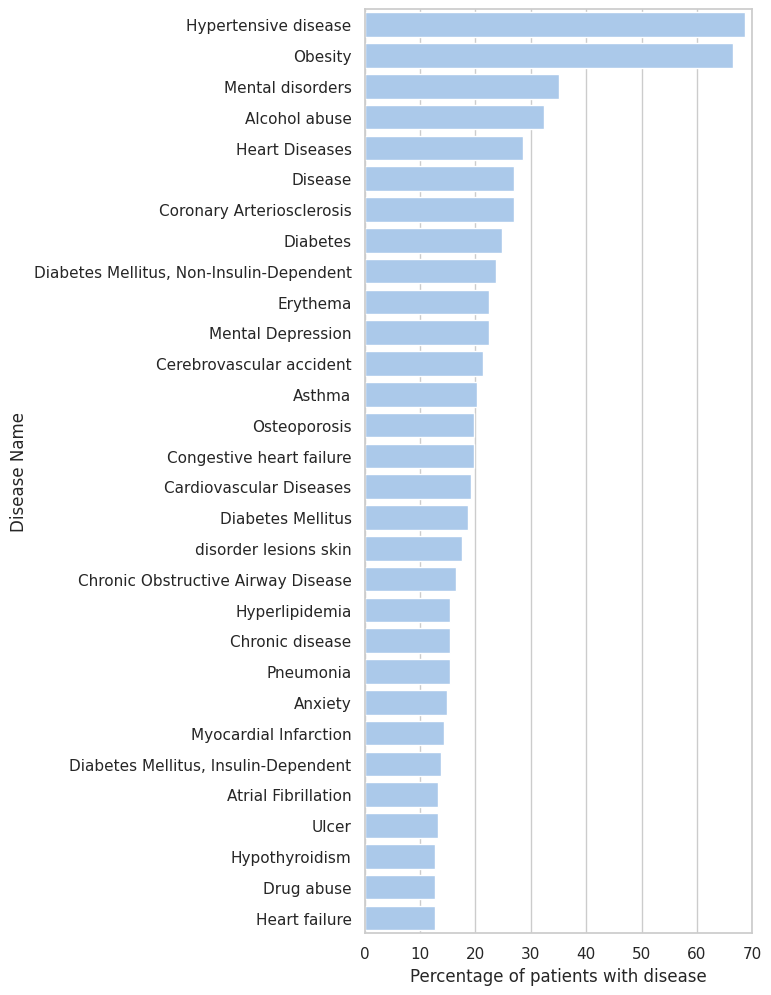

In [ ]:
# Plot the top 30 diseases
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(5,12)}, 
    style="whitegrid",
    palette='pastel'
)
f, ax = plt.subplots()
_data = df_cui_nsubjects.iloc[0:30]
sns.barplot(x="perc_subjects", y="name", data=_data, label="Disorder Name", color="b")
_ = ax.set(xlim=(0, 70), ylabel="Disease Name", xlabel="Percentage of patients with disease")
plt.show()

## Preparing data for supervised training (MedCATtrainer)

As we want to do some fine-tuning on the models and also some meta-annotations (e.g. Status and Temporality), we'll take the top 100 CUIs from each TUI and for each take 2 examples. We'll do this because randomly choosing documents will give us only (most likely) the concpets on the very top by frequency (especially when there is a large drop between the top concepts).

The required output format for supervised training via MedCATtrainer is CSV with `columns=(name, text)`

In [ ]:
df_cui_nsubjects.head()

,cui,nsubjects,tui,name,perc_subjects
0,C0020538,125,{T047},Hypertensive disease,68.681319
1,C0028754,121,{T047},Obesity,66.483516
2,C0004936,64,{T048},Mental disorders,35.164835
3,C0085762,59,{T048},Alcohol abuse,32.417582
4,C0018799,52,{T047},Heart Diseases,28.571429


In [ ]:
# For each of the top 30 diseases/mental_disorders take 2 examples of documents/text
#where they appear
nexamples = 2
size = 40
loc_047_top = []
loc_048_top = []

for cui in df_cui_nsubjects[df_cui_nsubjects['tui'].apply(lambda x: 'T047' in x)]['cui'].values[0:size]:
    loc_047_top.extend(np.array(cui_location[cui])[np.random.randint(0, len(cui_location[cui]), nexamples)])
    
for cui in df_cui_nsubjects[df_cui_nsubjects['tui'].apply(lambda x: 'T048' in x)]['cui'].values[0:size]:
    loc_048_top.extend(np.array(cui_location[cui])[np.random.randint(0, len(cui_location[cui]), nexamples)])

data_047_top = data.iloc[loc_047_top]
data_048_top = data.iloc[loc_048_top]

In [ ]:
# Combine everything
train_data = pd.concat([data_047_top, data_048_top])

In [ ]:
train_data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
36,69,9,2065-01-01,Office Notes,"HISTORY OF PRESENT ILLNESS:, This 57-year-old...",2065,9,F,2018-01-01,2018,47
758,1406,200,2066-01-01,Physical Medicine - Rehab,"DIAGNOSIS: , Left knee osteoarthritis.,HISTORY...",2066,200,F,2018-01-01,2018,48
1038,2001,284,2042-01-01,Consult - History and Phy.,"REASON FOR VISIT: , This is a cosmetic consult...",2042,284,F,2018-01-01,2018,24
169,316,43,2063-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...",2063,43,F,2018-01-01,2018,45
169,316,43,2063-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...",2063,43,F,2018-01-01,2018,45


In [ ]:
train_data = train_data.rename(columns={'Unnamed: 0_x': "name"})
train_data = train_data[['name', 'text']]
train_data.reset_index(drop=True, inplace=True)
train_data.head()

,name,text
0,69,"HISTORY OF PRESENT ILLNESS:, This 57-year-old..."
1,1406,"DIAGNOSIS: , Left knee osteoarthritis.,HISTORY..."
2,2001,"REASON FOR VISIT: , This is a cosmetic consult..."
3,316,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye..."
4,316,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye..."


In [ ]:
# Remove duplicates if we have them. 
train_data = train_data.drop_duplicates(['text'])

# Save the data so that it can be imported into MedCATtrainer
train_data.to_csv(DATA_DIR + "train_data.csv", index=False)